In [1]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import aligater as ag

In [4]:
fcsList=ag.collectFiles("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/", lFilter=["B cell"])

Collected 3022 files, 6347 files did not pass filter(s) and mask(s).

In [5]:
fcsDF = ag.loadFCS(fcsList[0], compensate=True)

Opening file B cells_A11_A11_033 from folder /01-03-2016/plate 1
Loaded dataset with 500000 events.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 

38623.6
50001.0


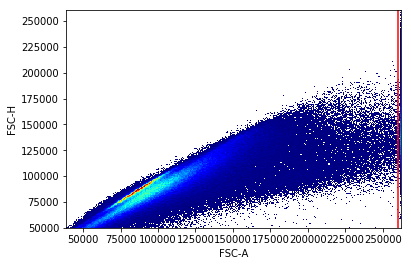

38623.6
50001.0


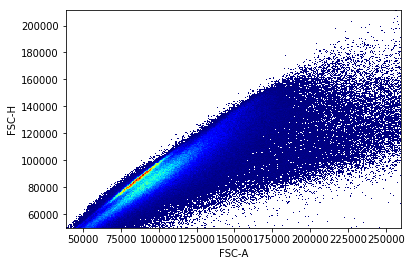

After gating, 490615 out of 500000 events remain.

In [6]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A", "FSC-H",thresh=260000, orientation='horisontal',population="lower")

After gating, 462765 out of 490615 events remain.

38623.6
50001.0


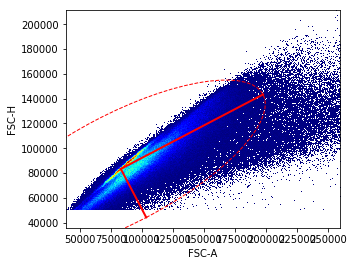

38623.6
50001.0


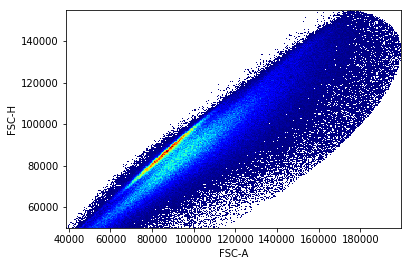

In [8]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='density',widthScale=3, heightScale=4, vI=no_clutter, plot=True)

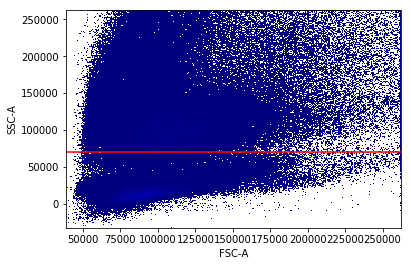

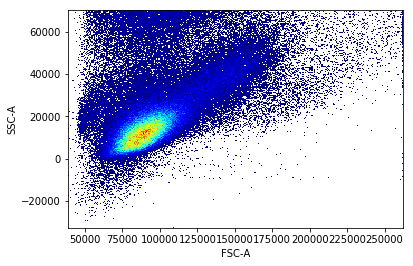

After gating, 179603 out of 500000 events remain.

In [9]:
PBMCstep1=ag.gateThreshold(fcsDF,xCol="FSC-A",yCol="SSC-A",orientation="vertical",thresh=70000,population="lower")

After gating, 161645 out of 179603 events remain.

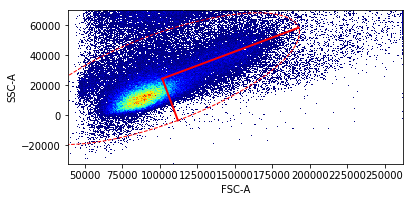

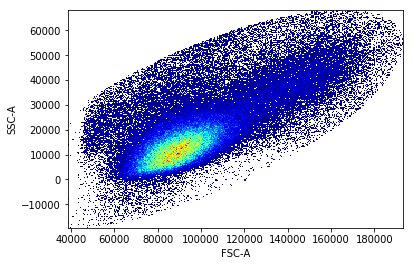

In [10]:
PBMC=ag.gatePC(fcsDF,"FSC-A","SSC-A",center='centroid',widthScale=3, heightScale=2, vI=PBMCstep1, plot=True)

In [15]:
mean, sigma, maxVal=ag.axisStats(fcsDF, "CD34", PBMC)
sigma*3

1611.4166648803389

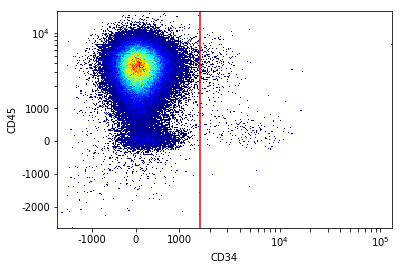

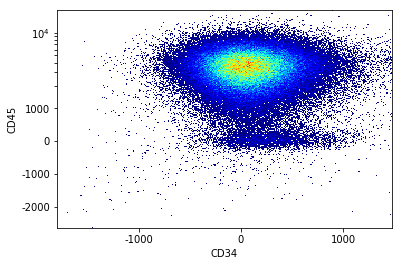

After gating, 160961 out of 161645 events remain.

In [16]:
CD45step1 = ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='horisontal', vI=PBMC,population="lower",thresh=(3*sigma), scale='logish')

In [42]:
lim = ag.valleySeek(fcsDF, "CD45",vI=CD45step1,interval=[0,2500],sigma=2,bins=1000)

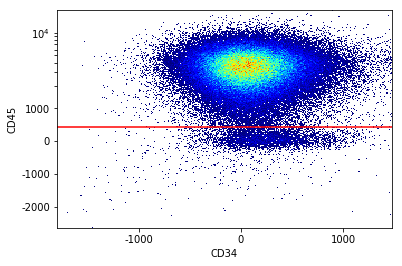

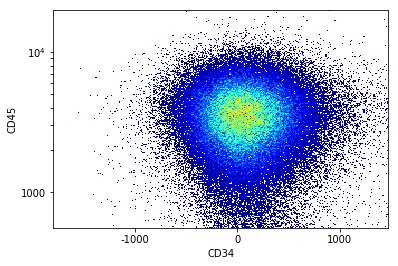

After gating, 154464 out of 160961 events remain.

In [44]:
CD45pos = ag.gateThreshold(fcsDF, "CD34", "CD45", vI=CD45step1, orientation='vertical',thresh=lim,scale='logish') 

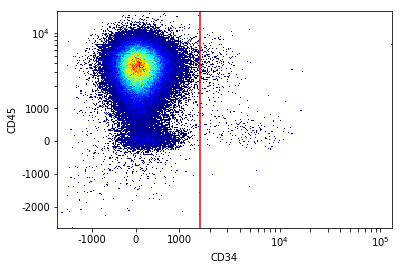

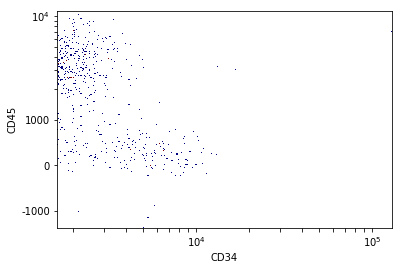

After gating, 684 out of 161645 events remain.

In [45]:
CD34step1=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='horisontal', vI=PBMC,population="upper",thresh=(3*sigma), scale='logish')

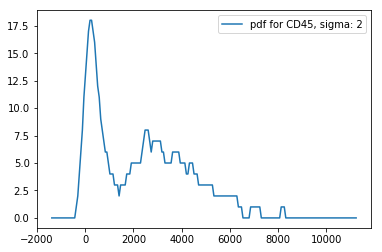

In [82]:
ag.plot_densityFunc(fcsDF,"CD45", vI=CD34step1,sigma=2,bins=200)

In [83]:
lim=ag.valleySeek(fcsDF, "CD45",vI=CD34step1,interval=[500,2500],sigma=2,bins=200)
lim

1423.5755325992864

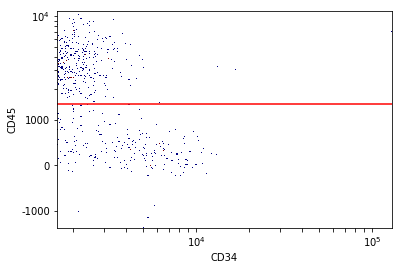

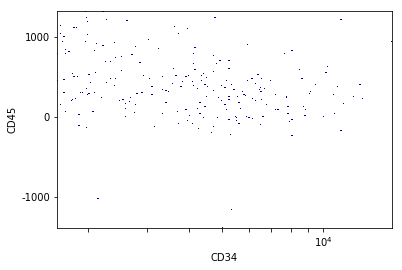

After gating, 266 out of 684 events remain.

In [84]:
CD34pos=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=CD34step1,population="lower",thresh=lim, scale='logish')